# This notebook contains preliminary results

In [97]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

from pathlib import Path
from haberrspd.__init_paths import data_root
from haberrspd.preprocess import (sentence_level_pause_correction_mjff,
                                  select_attempt,
                                  backspace_corrector,
                                  create_mjff_baselines,
                                  calculate_all_baseline_ROC_curves,
                                  create_MJFF_dataset,
                                  get_iki_baseline_df,
                                  remap_English_MJFF_participant_ids)
from haberrspd.plotting import plot_roc_curve_simple, plot_superimposed_roc_curves, nice_fonts
import pandas as pd
import numpy as np

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib as mpl
import matplotlib.pyplot as plt


# Settings for plotting

# plt.style.use('dark_background')
# Set to default again
plt.rcParams.update(plt.rcParamsDefault)
# mpl.rcParams.update(nice_fonts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df1 = select_attempt(df,df_meta,1)

In [8]:
df_iki = get_iki_baseline_df(df1, df_meta, 1)

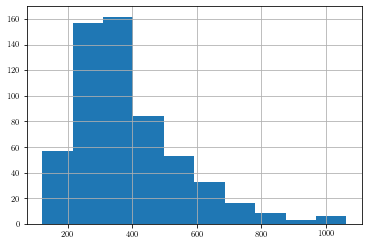

In [7]:
# invokation -1
df_iki.Mean_IKI.hist()

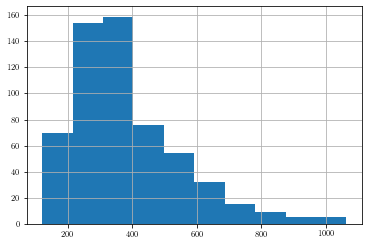

In [9]:
# invokation 1
df_iki.Mean_IKI.hist()

# Baseline classifiers

In [89]:
# Load data
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishData-duplicateeventsremoved.csv')
df_meta = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishParticipantKey.csv',
                      header=0,
                      names=["participant_id", "ID", "attempt", "diagnosis"],
                     )

In [91]:
df_baselines_raw = create_mjff_baselines(df,df_meta,attempt=1,invokation_type=-1) # No changes have been made
df_baselines_edited = create_mjff_baselines(df,df_meta,attempt=1,invokation_type=1) # Error corrections have been made

In [158]:
out1 = calculate_all_baseline_ROC_curves(df_baselines_raw)
out2 = calculate_all_baseline_ROC_curves(df_baselines_edited)

In [148]:
from sklearn.metrics import auc, roc_curve
import seaborn as sns
import datetime

In [154]:
def plot_superimposed_roc_curves(data: dict, filename=None) -> None:

    if filename:
        assert type(filename) == str
        
    if ~isinstance(data,dict):
        # We've been passed a list of dicts
        assert all([isinstance(x,dict) for x in data])        
        # Combine them
        if len(data) == 2:
            assert set(['I',"II"]).issubset(data[0].keys())
            assert set(['I',"II"]).issubset(data[1].keys())
            data[1]['III'] = data[1].pop('I')
            data[1]['IV'] = data[1].pop('II')
            data = {**data[0], **data[1]}
        else:
            raise ValueError
        

    # Set styles for paper
    sns.set_context("paper")
    mpl.rcParams.update(nice_fonts)

    lw = 2
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    # Number of colours per model
    kk = len(data) // 2
    palette = sns.color_palette("Blues", kk)
    red_palette = sns.color_palette("Greens", kk)
    palette.extend(red_palette)
    for i, item in enumerate(data.keys()):
        y_true, y_scores = data[item]
        # Main calculations here
        fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)
        # Calculate area under the ROC curve here
        auc = np.trapz(tpr, fpr)
        ax.plot(fpr, tpr, 
                color=palette[i], 
                lw=lw,
                alpha=0.7,
                label="%s: AUC = %0.2f" % (item, auc))

    ax.plot([0, 1], [0, 1], color="gray", lw=lw, linestyle="--", alpha=0.25)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    # Legend
    ax.legend(loc="lower right",ncol=1, framealpha=1, fancybox=False, borderpad=0.5)
    # Grid
    ax.grid(True, alpha=0.2)

    if filename:
        # Set reference time for save
        now = datetime.datetime.now()
        fig.savefig(
            "../figures/baseline_roc_curves-" + filename + "-" + now.strftime("%Y-%m-%d-%H:%M") + ".pdf",
            bbox_inches="tight",
        )
    else:
        plt.show()

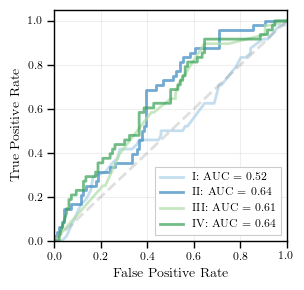

In [159]:
plot_superimposed_roc_curves([out1,out2],'test')

# Modelling CHARACTERS ('char') only

This commences the CNN approach to the task.

In [66]:
char = {100 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-03-33.csv', delimiter=','), 
        200 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_16-37-21.csv', delimiter=','), 
        500 : np.genfromtxt('../results/char/label_and_label_probs_2019-07-30_17-46-29.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



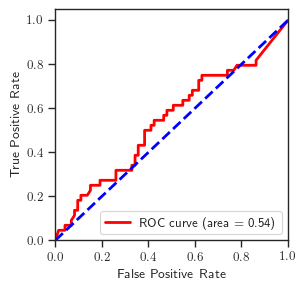

Number of hyperparameter permutations considered: 200



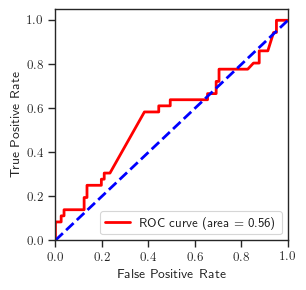

Number of hyperparameter permutations considered: 500



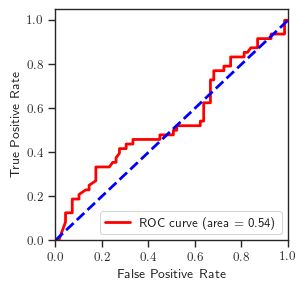

In [67]:
for key in char.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char[key][:,0].astype(np.int64), char[key][:,1])

In [68]:
plot_roc_curve_simple(char[200][:,0].astype(np.int64), char[200][:,1],'mjff_char_only')

# CHARACTERS and TIME

In [69]:
char_time = {100 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_21-25-18.csv', delimiter=','), 
 200 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_15-00-06.csv', delimiter=','), 
 500 : np.genfromtxt('../results/char_time/label_and_label_probs_2019-07-26_12-24-09.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



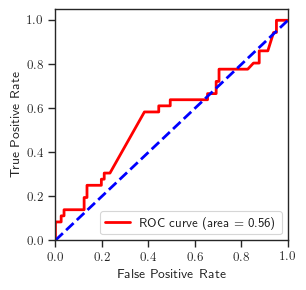

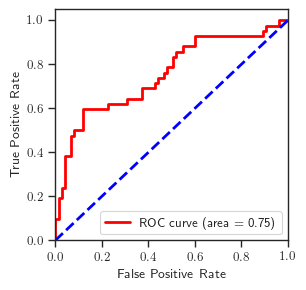

Number of hyperparameter permutations considered: 200



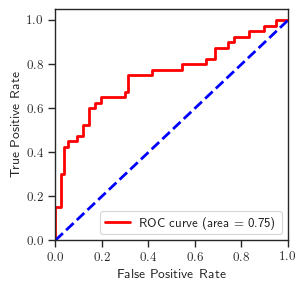

Number of hyperparameter permutations considered: 500



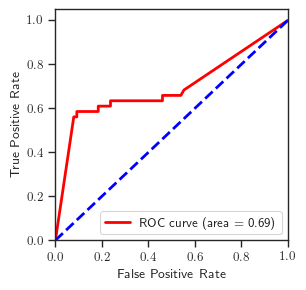

In [70]:
for key in char_time.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time[key][:,0].astype(np.int64), char_time[key][:,1])

In [71]:
plot_roc_curve_simple(char_time[200][:,0].astype(np.int64), char_time[200][:,1],'mjff_char_time')

# CHARACTERS and TIME and Space

In [72]:
char_time_space = {100 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_15-46-27.csv', delimiter=','), 
                   500 : np.genfromtxt('../results/char_time_space/label_and_label_probs_2019-07-30_21-34-27.csv', delimiter=',')}

Number of hyperparameter permutations considered: 100



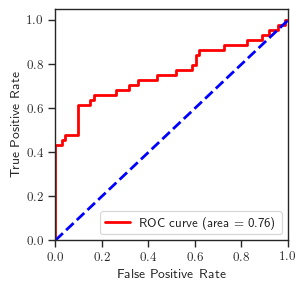

Number of hyperparameter permutations considered: 500



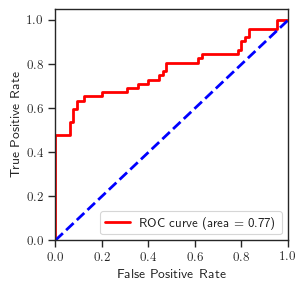

In [74]:
for key in char_time_space.keys():
    print("Number of hyperparameter permutations considered: {}\n".format(key))
    plot_roc_curve_simple(char_time_space[key][:,0].astype(np.int64), char_time_space[key][:,1])

In [75]:
plot_roc_curve_simple(char_time_space[500][:,0].astype(np.int64), char_time_space[500][:,1],'mjff_char_time_space')

In [54]:
# Check the details of the best model for one of the optimisations
df = pd.read_csv("../results/char_time_space/073019144454.csv")

In [57]:
# Sort by validation accuracy
df.sort_values(by=['val_acc'],ascending=False).head(10)

,round_epochs,val_loss,val_acc,loss,acc,alphabet_size,batch_size,control_class_weight,conv_activation,conv_bias_initializer,...,last_activation,loss.1,lr,max_sentence_length,number_of_large_filters,number_of_small_filters,optimizer,pd_class_weight,pool_length,small_filter_length
387,8,0.086684,0.786325,0.093786,0.721640,51,16,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,1,<class 'keras.optimizers.Adam'>,1.402406,2,20
326,13,0.560294,0.777778,0.469171,0.789323,51,32,0.777037,relu,uniform,...,sigmoid,binary_crossentropy,2.08,14000,2,4,<class 'keras.optimizers.Adam'>,1.402406,2,10
126,13,0.088169,0.777778,0.083724,0.763584,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,2.08,14000,1,4,<class 'keras.optimizers.Adam'>,1.402406,2,5
448,16,0.086703,0.777778,0.071692,0.789323,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,1,<class 'keras.optimizers.Nadam'>,1.402406,2,20
248,7,0.089374,0.777778,0.103207,0.716873,51,16,0.777037,relu,uniform,...,sigmoid,logcosh,4.06,14000,2,4,<class 'keras.optimizers.Adam'>,1.402406,2,10
201,11,0.079817,0.777778,0.087058,0.747378,51,16,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,2,<class 'keras.optimizers.Nadam'>,1.402406,2,20
404,15,0.084064,0.769231,0.093846,0.751192,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,2.08,14000,4,4,<class 'keras.optimizers.Adam'>,1.402406,2,10
460,16,0.079845,0.769231,0.073406,0.779790,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,2,<class 'keras.optimizers.Nadam'>,1.402406,2,20
165,19,0.086417,0.769231,0.092666,0.753098,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,4,4,<class 'keras.optimizers.Nadam'>,1.402406,2,10
74,20,0.080932,0.769231,0.075629,0.777884,51,32,0.777037,relu,uniform,...,sigmoid,logcosh,0.10,14000,2,1,<class 'keras.optimizers.Adam'>,1.402406,2,10


In [62]:
# Detailed look at the "winning model"
df.iloc[387,:]

round_epochs                                              8
val_loss                                          0.0866844
val_acc                                            0.786325
loss                                              0.0937864
acc                                                 0.72164
alphabet_size                                            51
batch_size                                               16
control_class_weight                               0.777037
conv_activation                                        relu
conv_bias_initializer                               uniform
conv_kernel_initializer                             uniform
conv_output_space                                        16
dense_activation                                       relu
dense_bias_initializer                              uniform
dense_kernel_initializer                            uniform
dense_units_layer_2                                      32
dense_units_layer_3                     